In [1]:
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix, f1_score, average_precision_score, cohen_kappa_score
from inspect import signature
from sklearn.externals import joblib
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.externals.six import StringIO 

C:\Users\Pappa\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Pappa\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## 1. Prepare Data

In [2]:
X_train_resampled = pd.read_csv("../3. Data Preparation/X_train_resampled.csv", index_col=0)
X_train_resampled.shape

(1848, 30)

In [3]:
y_train_resampled = pd.read_csv("../3. Data Preparation/y_train_resampled.csv", index_col=0)
y_train_resampled.shape

(1848, 1)

In [4]:
X_val = pd.read_csv("../3. Data Preparation/X_val.csv", index_col=0)
X_val.shape

(56962, 30)

In [5]:
y_val = pd.read_csv("../3. Data Preparation/y_val.csv", index_col=0, header=0)
y_val.shape

(56962, 1)

In [6]:
target_names=['Not Fraud 0', 'Fraud 1']

## 2. Load Decision Tree Model

In [ ]:
dTree = joblib.load('DecisionTree-gini.pkl') 
n_trees = 21 # odd number just after the middle of the features number

## 3. AdaBoost Classifier

In [8]:


model_AdaBoost = AdaBoostClassifier(base_estimator=dTree, n_estimators=n_trees, learning_rate=0.1)
model_AdaBoost.fit(X_train_resampled, y_train_resampled['Class'].values)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [9]:
y_pred_val = model_AdaBoost.predict(X_val)

## 4. Features Importance

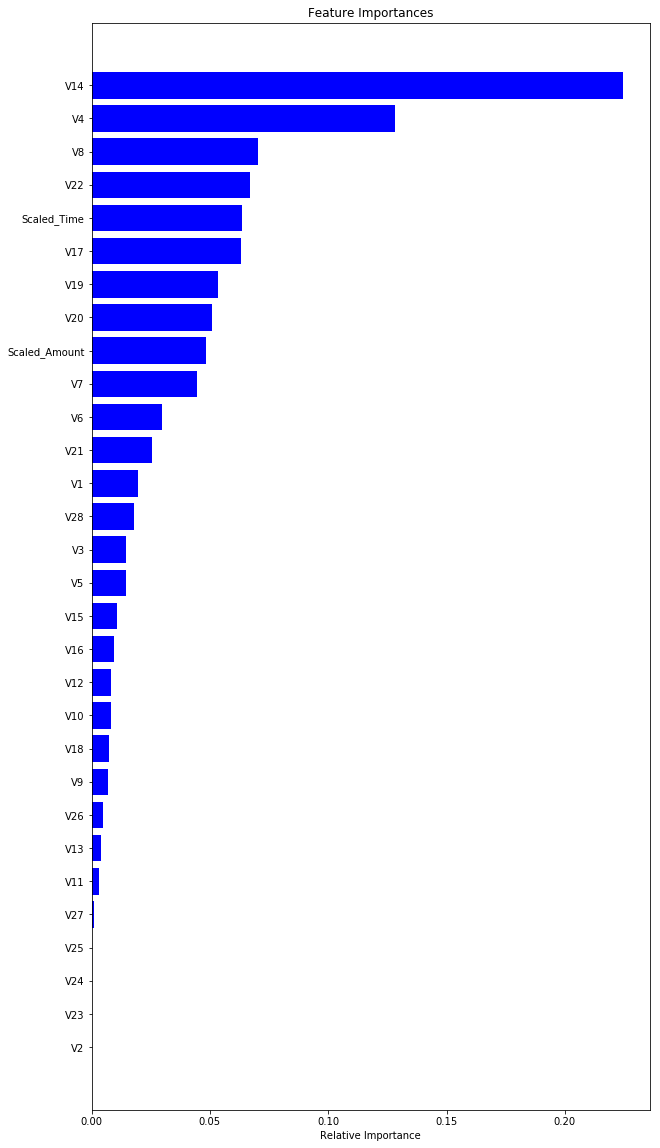

In [10]:
features = X_train_resampled.columns
importances = model_AdaBoost.feature_importances_
indices = np.argsort(importances)
fig, ax = plt.subplots(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('Importance_Features Random Forest OOB 12.png')
plt.show()

## 5. Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


np.set_printoptions(precision=2)


Confusion matrix, without normalization
[[56490   375]
 [   13    84]]


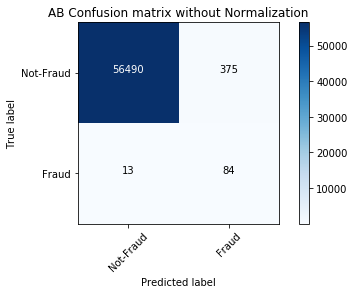

Normalized confusion matrix
[[0.99 0.01]
 [0.13 0.87]]


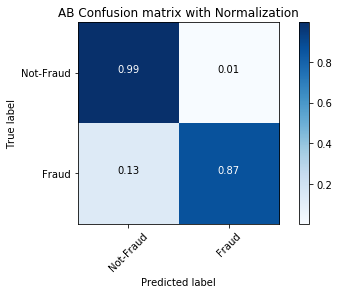

In [12]:
cm = confusion_matrix(y_val['Class'].values, y_pred_val)

class_names = ['Not-Fraud','Fraud']
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names , 
                      title = 'AB Confusion matrix without Normalization')
plt.show()

plot_confusion_matrix(cm, 
                      classes = class_names , 
                      normalize = True,
                      title = 'AB Confusion matrix with Normalization')
plt.show()



## 6. Metrics Scores

In [13]:
print(classification_report(y_val['Class'].values, y_pred_val, target_names=target_names))

              precision    recall  f1-score   support

 Not Fraud 0       1.00      0.99      1.00     56865
     Fraud 1       0.18      0.87      0.30        97

    accuracy                           0.99     56962
   macro avg       0.59      0.93      0.65     56962
weighted avg       1.00      0.99      1.00     56962



In [14]:
total1=sum(sum(cm))


sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9934581904510683
Specificity :  0.865979381443299


In [15]:

acc= accuracy_score( y_val['Class'].values, y_pred_val)
recall = recall_score( y_val['Class'].values, y_pred_val, average='binary')
precision = precision_score( y_val['Class'].values, y_pred_val)
f1 = f1_score(y_val['Class'].values, y_pred_val,  average='binary')
average = average_precision_score( y_val['Class'].values, y_pred_val)
kappa = cohen_kappa_score( y_val['Class'].values, y_pred_val)

print('Accuracy', acc)
print('Recall score', recall)
print('Precision', precision)
print('f1_score', f1)
print ('Average precision-recall score: {0:0.2f}'.format(average))
print('Kappa Score', kappa)

Accuracy 0.9932411081071592
Recall score 0.865979381443299
Precision 0.18421052631578946
f1_score 0.3037974683544304
Average precision-recall score: 0.16
Kappa Score 0.3018367591357082


## 7. Save Scores

In [16]:
model_Results = pd.DataFrame([['AdaBoost Simple Classifier', acc, precision, recall, f1, average, kappa, specificity1, sensitivity1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Average', 'Kappa Cohen', 'Specificity', 'Sensitivity'])

In [17]:
result = pd.read_csv("../Results/model_Result_final.csv", index_col=0)

In [18]:
result.columns

Index(['Accuracy', 'Average', 'F1 Score', 'Kappa Cohen', 'Model', 'Precision',
       'Recall', 'Sensitivity', 'Specificity'],
      dtype='object')

In [19]:
x = result.append(model_Results, ignore_index=True)

In [20]:
x.to_csv("../Results/model_Result_final.csv")

In [21]:
x

,Accuracy,Average,F1 Score,Kappa Cohen,Model,Precision,Recall,Sensitivity,Specificity
0,0.996647,0.277870,0.467967,0.466641,Random Forest All Features,0.320611,0.865979,0.996870,0.865979
1,0.993908,0.174253,0.326214,0.324346,Random Forest (n=27) with OOB_9,0.200957,0.865979,0.994126,0.865979
2,0.995225,0.219926,0.387387,0.385752,Random Forest (n=35) with OOB_12,0.247839,0.886598,0.995410,0.886598
3,0.993241,0.159751,0.303797,0.301837,AdaBoost Simple Classifier,0.184211,0.865979,0.993458,0.865979


In [22]:
precision, recall, _ = metrics.precision_recall_curve(y_val['Class'].values, y_pred_val)

In [23]:
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve' , linewidth = 2, color= 'darkorange')
    plt.plot([0,1],[0,1], 'k--', linewidth = 2, color ='navy', linestyle='--')
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

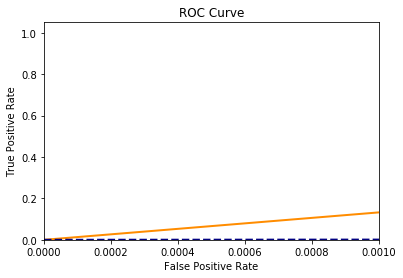

In [24]:
fpr, tpr, t = metrics.roc_curve(y_val['Class'].values, y_pred_val)
plot_roc()

Text(0.5,1,'Precision-Recall curve: AP=0.16')

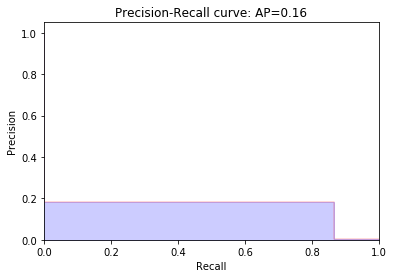

In [25]:
# plot precision-recall score


precision, recall, _ = metrics.precision_recall_curve(y_val['Class'].values, y_pred_val)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average))

## 8. Save Model

In [26]:
joblib.dump(model_AdaBoost, 'AdaBoost Classifier.pkl') 

['AdaBoost Classifier.pkl']